In [1]:
# Fetch the data
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_PATH = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
LOCAL_PATH = "datasets/housing"
DATA_URL = DOWNLOAD_PATH + LOCAL_PATH + "/housing.tgz"

In [3]:
def fetch_data(url=DATA_URL, path=LOCAL_PATH):
    if(not os.path.isdir(path)):
        os.mkdirs(path)
    tgz_path = os.path.join(path, "housing.tgz")
    urllib.request.urlretrieve(url, path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extract_all(path=path)
    housing_tgz.close()

In [4]:
# load the data
import pandas as pd

def load_housing_data(path=LOCAL_PATH):
    data_path = os.path.join(path, "housing.csv")
    return pd.read_csv(data_path)

In [5]:
house_data = load_housing_data()
house_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### First Look @ data

In [6]:
# For quick description of the data -> check for N/A values
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### Observations:
- The feature total_bedrooms has some NULL values
- All features except ocean proximity are real values. Ocean Proximity is string -> must be taken as categorical attribute

In [7]:
# To see how manny categories & how many data points in each category
house_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# describe shows a summary of numerical attributes
house_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


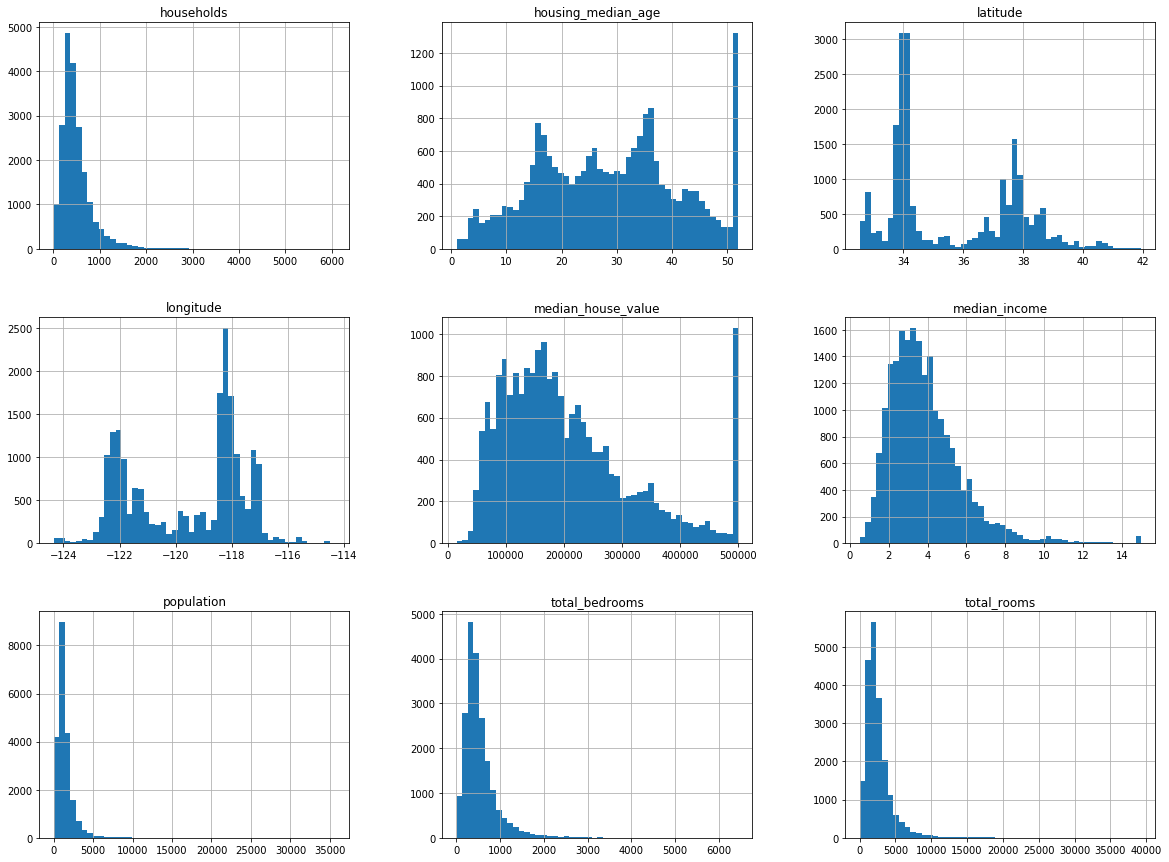

In [9]:
# Visualizing the numerical attributes
%matplotlib inline
from matplotlib import pyplot as plt
house_data.hist(bins=50, figsize=(20,15))
plt.show() # Calling show() is optional in Jupyter Notebook if inline is enabled

#### Observations:
- Median income is capped at 15 (not absolute value)
- Different attributes are in differnt ranges
- They are not exactly bell-shaped (tail-heavy: extend much farther from the median to the right than the left)
- Median age & median house value (Label ->important) were also capped

### Split the data as train & test

In [10]:
# Before lookking into data further, we need to create a test set & leave it aside
import numpy as np
np.random.seed(42)
def split_test_train(data, test_ratio=0.2):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_data = shuffled_indices[:test_size]
    train_data = shuffled_indices[test_size:]
    return data.iloc[test_data], data.iloc[train_data]

In [11]:
test_data, train_data = split_test_train(house_data, 0.2)

In [12]:
print("Train:{} samples".format(len(train_data)))
print("Test: {} samples".format(len(test_data)))

Train:16512 samples
Test: 4128 samples


The above approach for generating test set will break if the data gets augmented. So another good approach is to use hashing on some attribute/ row index and based on some criteria, classify it as test or train

In [13]:
import hashlib
'''
Compute a hash of each instance’s identifier, keep only the last
byte of the hash, and put the instance in the test set if this value is lower or equal to
51 (~20% of 256).
'''
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [14]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = house_data.reset_index() #Add index column
train_data, test_data = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
test_data.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


Can also split using the sklearn lib's train_test_split

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(house_data, test_size=0.2, random_state=42)

In [18]:
test_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Another approach is <b>Stratified Sampling</b>. the population is divided into homogeneous subgroups called strata,
and the right number of instances is sampled from each stratum to guarantee that the
test set is representative of the overall population.

Let's say we want to ensure that the test set is representative of different categories of income in the whole dataset. Since median income is a continous attribute, we first convert it into a categorical attribute

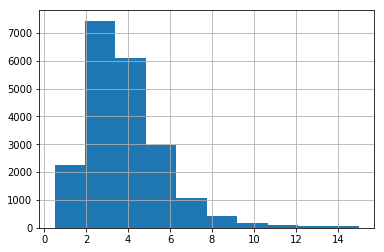

In [19]:
house_data['median_income'].hist()

In [20]:
# Convert it to categorical values
house_data['income_cat'] = pd.cut(house_data['median_income'],
                                 bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                                 labels=[1, 2, 3, 4, 5])

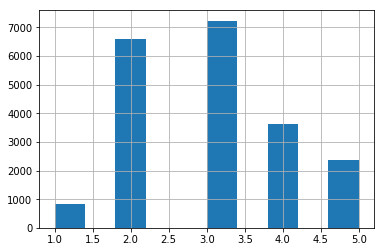

In [21]:
house_data['income_cat'].hist()

#### Note:
Most values are between 2-5, but some go beyond 6 as well

In [22]:
# Use stratified split from sklearn
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(house_data, house_data["income_cat"]):
    strat_train_data = house_data.loc[train_index]
    strat_test_data = house_data.loc[test_index]

Note that the proportions of diff income categories in strat_test_data is similar to the overall data as shown below

In [23]:
strat_test_data["income_cat"].value_counts()/len(strat_test_data)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [24]:
house_data["income_cat"].value_counts()/len(house_data)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

### Visualizing Geographical data

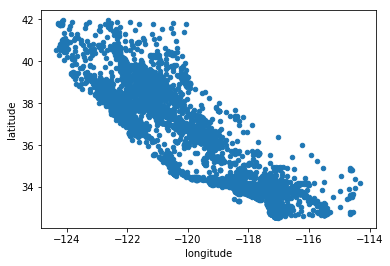

In [25]:
house_data.plot(kind='scatter', x='longitude', y='latitude')

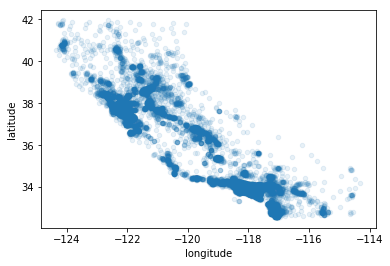

In [26]:
# Setting alpha -> helps to visualize density of points in diff regions
house_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

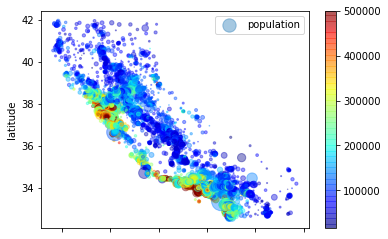

In [27]:
# Now let's visualize the population & median house price
# s -> radius of circle, c-> color
house_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
                s=house_data['population']/100, c=house_data['median_house_value'],
               label = 'population', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

### Check for correlations

There are 2 ways to look at correlation between different attributes. One is to compute the std correlation coeff using <b>corr()</b>. The other is <b>scatter matrix</b> in pandas df

In [28]:
corr_matrix = house_data.corr()

In [29]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Looks like median_income is highly correlated with median_house_value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87fc81af28>,
      dtype=object)

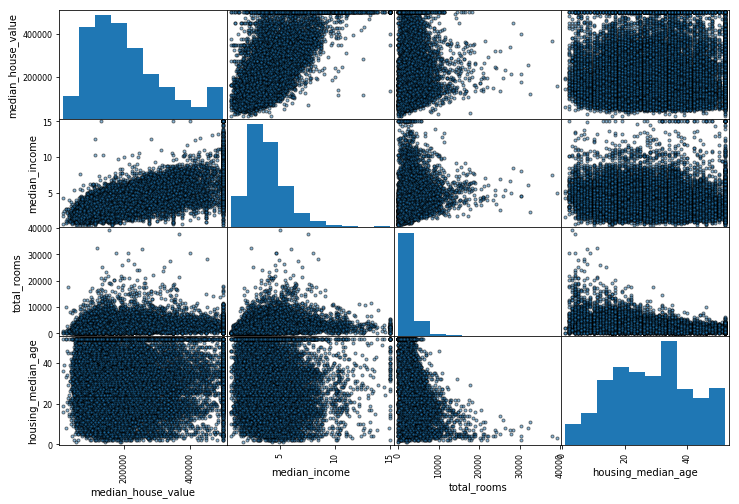

In [30]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(house_data[attributes], figsize=(12, 8), edgecolor='black')

In [31]:
# Checking new attributes:
house_data['rooms_per_household'] = house_data['total_rooms']/house_data['households']
house_data['bedrooms_per_room'] = house_data['total_bedrooms']/house_data['total_rooms']
house_data['population_per_household'] = house_data['population']/house_data['households']

In [32]:
corr_matrix = house_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

bedroom per room is more correlated than total rooms or total bedrooms

### Prepare the data

In [33]:
train_data = strat_train_data.drop('median_house_value', axis=1)
train_labels = strat_train_data['median_house_value'].copy()

### Data Cleaning:
 - You can either drop the entire attribute with null values
 - Or get rid of the corresponding points
 - Or fill it with 0, median -> fillna(), imputer

In [34]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')
# Only keep numerical attributes for Impbuter
housing_num = train_data.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [36]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [37]:
X = imputer.transform(housing_num) #This gives a numpy array-> converting back to pandas df
X_train = pd.DataFrame(X, columns=housing_num.columns)

In [38]:
# Fix categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = house_data['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)

In [39]:
housing_cat_encoded

array([3, 3, 3, ..., 1, 1, 1])

In [40]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


#### Note:
The problem with using values for categorical attribute is that the learner tends to assume that 2 nearby values(like 0 & 1) are more similar than other distant values (0 & 4), which is not the case. So the solution is <b>One-Hot Encoding</b>. See OneHotEncoder & LabelBinarizer

In [41]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)

In [42]:
housing_cat_1hot

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [49]:
# Add custom transformer -> similar to scikit
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(house_data.columns).index(col)
    for col in ('total_rooms', 'total_bedrooms', 'population', 'households')]
class CombinedAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        if(self.add_bedrooms_per_room):
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[rooms_per_household, population_per_household, 
                          bedrooms_per_room]
        else:
            return np.c_[rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributes(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.fit_transform(house_data.values)

In [50]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(house_data.values)

In [51]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns = list(house_data.columns)+['rooms_per_household', 'population_per_household'],
    index = house_data.index)

housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.98413,0.146591,2.55556,6.98413,2.55556
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.23814,0.155797,2.10984,6.23814,2.10984
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,5,8.28814,0.129516,2.80226,8.28814,2.80226
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY,4,5.81735,0.184458,2.54795,5.81735,2.54795
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY,3,6.28185,0.172096,2.18147,6.28185,2.18147
